Digit recognition based on the MNIST dataset

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from scipy import ndimage
import tensorflow as tf

%matplotlib inline

Load MNIST test data

In [2]:
raw_training = np.loadtxt('/notebooks/mnist/train.csv', skiprows = 1, delimiter=',', dtype=np.float32)

Preprocess the raw images, normalize the training data and turn the labels into a one-hot matrix

In [3]:
pixel_depth = 255.;
image_size = 28
num_channels = 1
num_labels = 10

def preprocess_labels(labels):
    values = np.zeros((labels.shape[0], num_labels));
    for i in range(labels.shape[0]):
        values[i][labels[i]] = 1.0;
    return values;

def preprocess_data(input):
    return (input - (pixel_depth * 0.5)) / pixel_depth

def augment(input):
    total = input.shape[0]
    print(input[:,1:,:].shape)
    print(input[:,0,:].shape)
    def shift_up(input):
        return np.concatenate((input[:,1:,:], input[:,0,:].reshape(total, 1, 28)), axis = 1)
    def shift_down(input):
        return np.concatenate((input[:,27,:].reshape(total, 1, 28), input[:,:27,:]), axis = 1)
    def shift_left(input):
        return np.concatenate((input[:,:,1:], input[:,:,0].reshape(total, 28, 1)), axis = 2)
    def shift_right(input):
        return np.concatenate((input[:,:,27].reshape(total, 28, 1), input[:,:,:27]), axis = 2)
    
    up_shifted = shift_up(input)
    down_shifted = shift_down(input)
    left_shifted = shift_left(input)
    right_shifted = shift_right(input)
    
    up_left = shift_up(left_shifted)
    down_left = shift_down(left_shifted)
    up_right = shift_up(right_shifted)
    down_right = shift_down(right_shifted)
    
    return np.concatenate((input, up_shifted, down_shifted, left_shifted, right_shifted, 
                           up_left, down_left, up_right, down_right))

def augment_labels(input):
    return np.concatenate((input, input, input, input, input))

labels_all = augment_labels(preprocess_labels(raw_training[:, 0]))
print(labels_all.shape)
data_all = augment(preprocess_data(raw_training[:, 1:]).reshape(42000, image_size, image_size))


(210000, 10)
(42000, 27, 28)
(42000, 28)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Visually inspect the result to make sure the transformations worked

In [4]:
print(labels_all[:10,:])

[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]


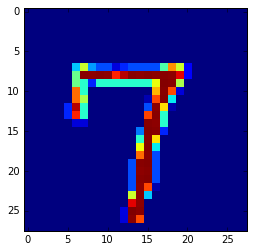

In [5]:
def show_image(index, data = data_all):
    plt.imshow(data[index].reshape((image_size, image_size)), interpolation='nearest')
    plt.show()

show_image(6)

Split the data into training, validation and testing sets

In [6]:
validation_set_size = 1000
training_end_index = data_all.shape[0] - validation_set_size

labels_train = labels_all[:training_end_index, :]
data_train = data_all[:training_end_index, :]

labels_test = labels_all[training_end_index:, :]
data_test = data_all[training_end_index:, :, :]


print(labels_train.shape)
print(data_train.shape)
print(labels_test.shape)
print(data_test.shape)

raw_test = np.loadtxt('/notebooks/mnist/test.csv', skiprows = 1, delimiter=',', dtype=np.float32)

final_test_data = preprocess_data(raw_test).reshape(raw_test.shape[0], image_size, image_size, 1)


(210000, 10)
(377000, 28, 28)
(0, 10)
(1000, 28, 28)


1


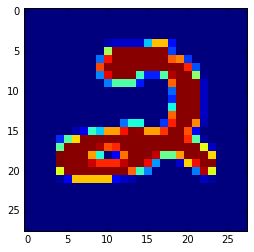

2


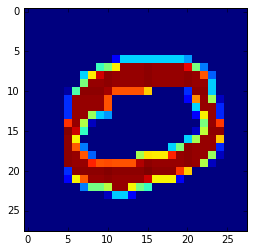

3


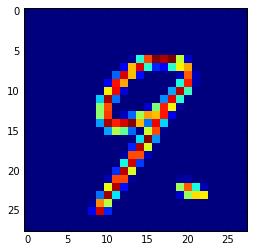

4


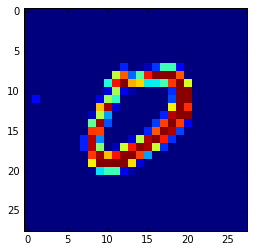

5


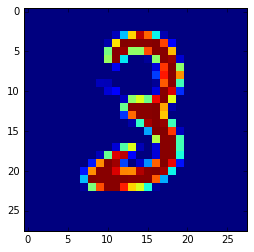

6


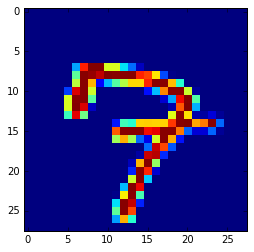

7


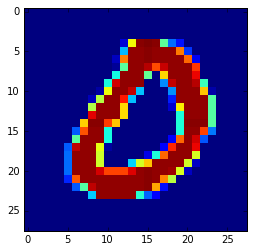

8


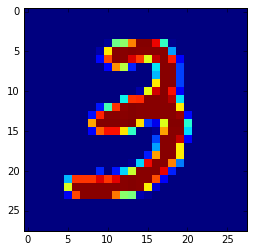

9


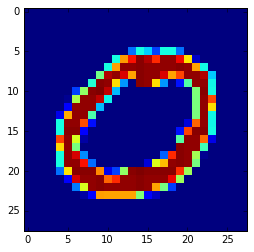

10


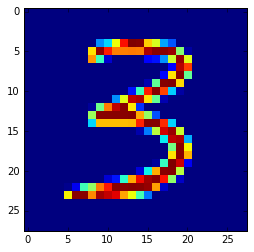

11


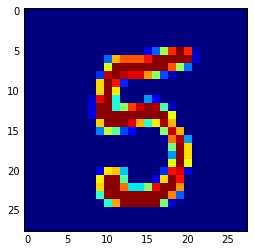

12


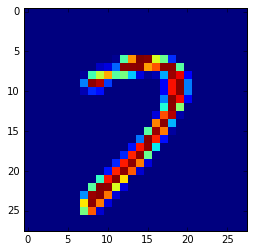

13


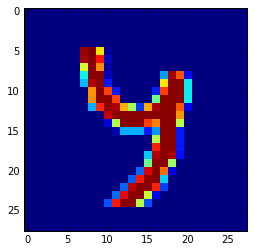

14


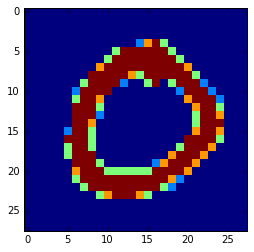

15


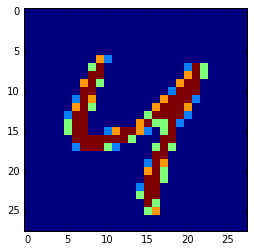

16


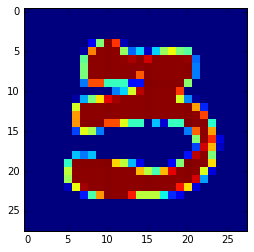

17


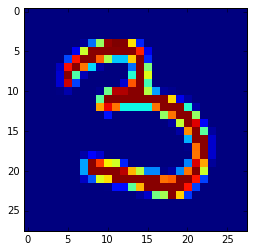

18


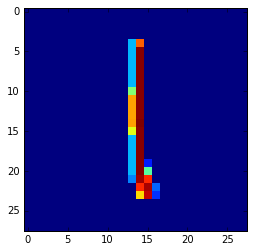

19


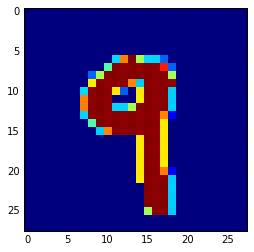

20


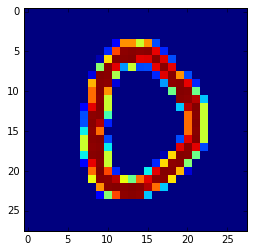

21


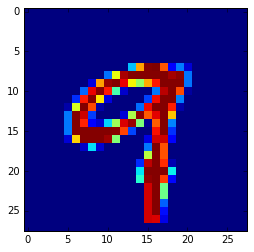

22


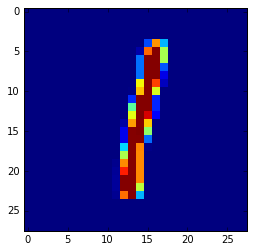

23


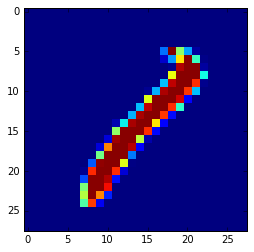

24


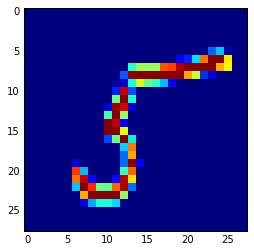

25


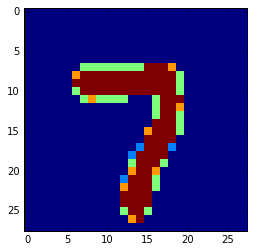

26


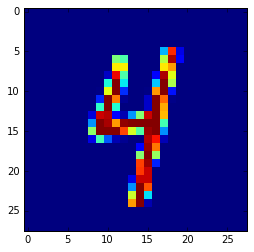

27


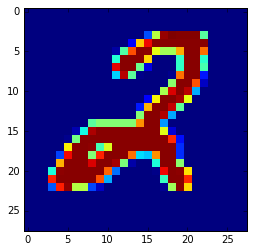

28


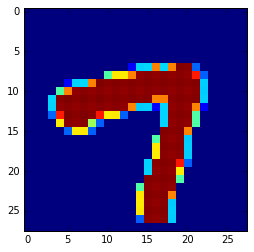

29


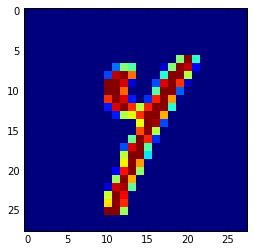

30


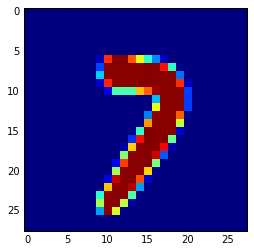

31


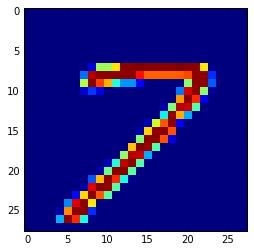

32


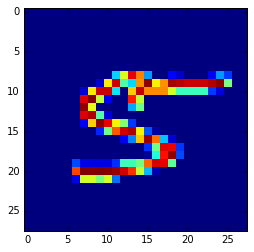

33


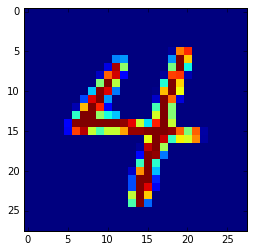

34


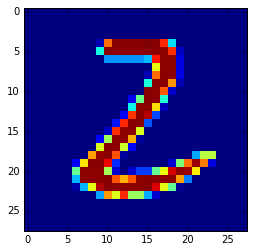

35


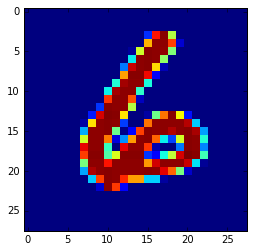

36


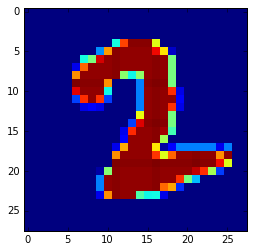

37


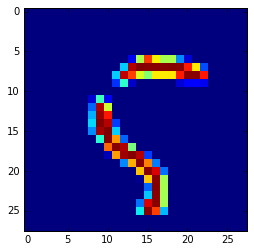

38


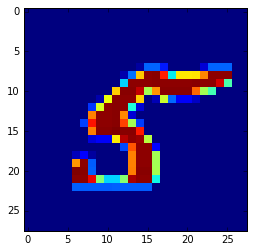

39


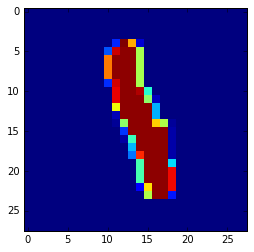

40


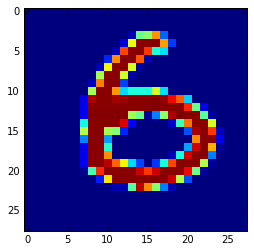

41


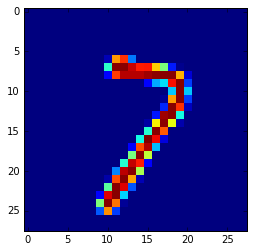

42


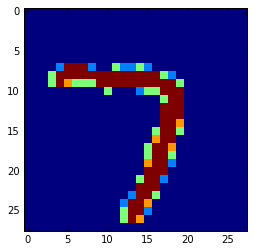

43


KeyboardInterrupt: 

In [7]:
for i in range(100):
    print(i+1)
    show_image(i, final_test_data)

In [8]:
final_test_labels = np.loadtxt('/notebooks/mnist/test_manual.csv', skiprows = 1, delimiter=',', dtype=np.float32)[:,1]
final_test_labels_1hot = preprocess_labels(final_test_labels)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [9]:
image_size = 28
num_channels = 1
batch_size = 16
patch_size = 5
depth1 = 16
depth2 = 16
num_hidden1 = 28 * 28
num_hidden2 = 32
num_hidden3 = 16
num_labels = 10

graph = tf.Graph()

with graph.as_default():
    
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_final_dataset = tf.placeholder(tf.float32, shape=(1000, image_size, image_size, num_channels))
    tf_valid_dataset = tf.constant(final_test_data[:100].reshape(100, image_size, image_size, num_channels))
    tf_test_dataset = tf.constant(data_test.reshape(1000, image_size, image_size, num_channels))
    

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth1]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
    layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4* depth2, num_hidden1], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]))
    #layer4_weights = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    #layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden1, num_hidden2], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))
    layer5_weights = tf.Variable(tf.truncated_normal([num_hidden2, num_hidden3], stddev=0.1))
    layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden3]))
    layer6_weights = tf.Variable(tf.truncated_normal([num_hidden3, num_labels], stddev=0.1))
    layer6_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    # Model.
    def model(data, keep_prob = 1.0):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        hidden = tf.nn.relu(tf.matmul(hidden, layer4_weights) + layer4_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        hidden = tf.nn.relu(tf.matmul(hidden, layer5_weights) + layer5_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        hidden = tf.nn.relu(tf.matmul(hidden, layer6_weights) + layer6_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        return hidden
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))
    
    result_prediction = tf.nn.softmax(model(tf_final_dataset))

In [10]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

Train model

In [13]:
import csv

num_steps = training_end_index / batch_size

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    print('Total steps %i' % num_steps)
    for step in range(num_steps):
        offset = (step * batch_size) % (labels_train.shape[0] - batch_size)
        batch_data = data_train[offset:(offset + batch_size), :, :].reshape(batch_size, image_size, image_size, num_channels)
        batch_labels = labels_train[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Progress: %.1f%%' % (100. * float(step) / float(num_steps)))
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), final_test_labels_1hot))
            print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), labels_test))
    
    with open('/notebooks/mnist/test_output.csv', 'w') as csvfile:
        fieldnames = ['ImageId','Label']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        num_steps = final_test_data.shape[0] / 1000
        for step in range(num_steps):
            offset = (step * 1000) % (final_test_data.shape[0] - 1000)
            results = result_prediction.eval({tf_final_dataset: final_test_data[offset:(offset + 1000), :, :, :]});
            #print(results[:10])
            predictions = np.argmax(results, 1)
            #print(predictions[:10])
            #show_image(0, final_test_data[offset:(offset + 1000), :, :, :].reshape((1000, 28,28)))
            for i in range(1000):
                writer.writerow({'ImageId': step * 1000 + i + 1, 'Label': predictions[i]})

Initialized
Total steps 23562
Progress: 0.00
Minibatch loss at step 0: 2.431383
Minibatch accuracy: 18.8%
Validation accuracy: 9.0%
Test accuracy: 0.0%
Progress: 0.21
Minibatch loss at step 50: 2.345218
Minibatch accuracy: 6.2%
Validation accuracy: 16.0%
Test accuracy: 0.0%
Progress: 0.42
Minibatch loss at step 100: 2.253315
Minibatch accuracy: 12.5%
Validation accuracy: 17.0%
Test accuracy: 0.0%
Progress: 0.64
Minibatch loss at step 150: 2.078008
Minibatch accuracy: 25.0%
Validation accuracy: 23.0%
Test accuracy: 0.0%
Progress: 0.85
Minibatch loss at step 200: 1.709307
Minibatch accuracy: 43.8%
Validation accuracy: 42.0%
Test accuracy: 0.0%
Progress: 1.06
Minibatch loss at step 250: 1.527862
Minibatch accuracy: 56.2%
Validation accuracy: 54.0%
Test accuracy: 0.0%
Progress: 1.27
Minibatch loss at step 300: 1.206851
Minibatch accuracy: 56.2%
Validation accuracy: 63.0%
Test accuracy: 0.0%
Progress: 1.49
Minibatch loss at step 350: 1.857325
Minibatch accuracy: 37.5%
Validation accuracy: 5